## pyKO Test 1b 3 layers
### Mie Gruneisen plates Al 700 m/s -> Cu -> Al, planar, free and fixed surfaces

Compare pyKO to fKO. 

NOTE: fortran version is hard-coded to 500 nodes for these tests. Edit and recompile if needed.

pyKO documentation: https://impactswiki.github.io/pyko

Set the path to pyko and your fortran compiler in import-modules.py file

Sarah T. Stewart<br>
June 27, 2023<br>

In [1]:
# import the same set of modules for each test run provided with pyKO
%run import-modules

Platform:  Darwin Kernel Version 22.5.0: Thu Jun  8 22:21:34 PDT 2023; root:xnu-8796.121.3~7/RELEASE_ARM64_T8112
python version:  3.11.4
matplotlib version:  3.7.1
hvplot version:  0.8.4
numpy version:  1.25.0
pandas version:  2.0.2
pickle version:  4.0
yaml version:  6.0
pint version:  0.22
pyko version:  v0.6-release-2023-06-27

/usr/local/bin/gfortran

GNU Fortran (GCC) 12.1.0
Copyright (C) 2022 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.




## Check the input file


In [2]:
# path to the input file
filein = './test1/test1b-mgrun.yml'

# initialize the run class variable by loading the configuration file
run = RunClass(fin=filein)
# print the run class state; this will print in code units
run.checkinput()
# the output filename is run.outputfilename

Key nrhomin does not exist. Using default 0.8
Key nrhomin does not exist. Using default 0.8
Key nrhomin does not exist. Using default 0.8

pyKO v0.6-release-2023-06-27 run parameters
   All outputs are in code units 
   Input file: ./test1/test1b-mgrun.yml 
   Output file: ./test1/pyko-test1b-mgrun-bin.dat 
   Number of materials: 3 
   Number of nodes in each material: [200 150 150] 
   Length of each material: [0.2 0.2 0.2] 
   Initial left edge of each material: [-0.2  0.   0.2] 
   Boundary conditions: ['FREE', 'FIXED']
   Material EOS:     ['MGR', 'MGR', 'MGR'] 
   Geometry:         PLA 
   Gravity:          0.0 
   Void pressure:    1e-09 
   Time step factor: 6 
   Stop time:        2.0

mat1 Von Mises parameters: 
   Shear modulus [Mbar]: 0.24800000000000003 
   Yield stress [Mbar]: 0.0030000000000000005

mat1 Fracture parameters: 
   Fracture pressure: 1000000000.0000001 
   Fracture maximum distension (rhomin/rhoref): 0.8

Class Mie Grueneisen Material Model: Al test 
   rhor

### Run python KO

Fortan version uses an initial time step of 0.001 microseconds; set as input here for code comparison.

Otherwise pyKO has an initialization section that estimates a good first time step


In [3]:

%time pyko.run(fin=filein,userdtstart=0.001,verbose=True)

Key nrhomin does not exist. Using default 0.8
Key nrhomin does not exist. Using default 0.8
Key nrhomin does not exist. Using default 0.8

pyKO v0.6-release-2023-06-27 run parameters
   All outputs are in code units 
   Input file: ./test1/test1b-mgrun.yml 
   Output file: ./test1/pyko-test1b-mgrun-bin.dat 
   Number of materials: 3 
   Number of nodes in each material: [200 150 150] 
   Length of each material: [0.2 0.2 0.2] 
   Initial left edge of each material: [-0.2  0.   0.2] 
   Boundary conditions: ['FREE', 'FIXED']
   Material EOS:     ['MGR', 'MGR', 'MGR'] 
   Geometry:         PLA 
   Gravity:          0.0 
   Void pressure:    1e-09 
   Time step factor: 6 
   Stop time:        2.0

mat1 Von Mises parameters: 
   Shear modulus [Mbar]: 0.24800000000000003 
   Yield stress [Mbar]: 0.0030000000000000005

mat1 Fracture parameters: 
   Fracture pressure: 1000000000.0000001 
   Fracture maximum distension (rhomin/rhoref): 0.8

Class Mie Grueneisen Material Model: Al test 
   rhor

## Load python KO results

In [4]:
# pyko output filename is in the input file
pykofileout = run.outputfilename
# initialize a class object to hold the output data
pko = [] # this variable will hold a plain (no units) pandas datafram for plotting
pkodata = OutputClass() # pandas + pint dataframe to read the pickled output data
#
# function to convert the stored pandas structure with pint units to a normal panda file
# hvplot tools do not work with a panda+pint file
# this also lets the user select a subset of variables to read into this notebook
def pyko_to_normal_panda(pkodata):
    df = pd.DataFrame({
            "j"    : pkodata.j.magnitude,
            "stepn" : pkodata.stepn.magnitude,
            "time" : pkodata.time.magnitude,
            "mat" : pkodata.mat.magnitude,
            "pos" : pkodata.pos.magnitude,
            "rho0" : pkodata.rho0.magnitude,
            "rho" : pkodata.rho.magnitude,
            "up" : pkodata.up.magnitude,
            "ie" : pkodata.ie.magnitude,
            "pres" : pkodata.pres.magnitude,
            "mass" : pkodata.mass.magnitude,
            "temp" : pkodata.temp.magnitude,
            "sigmar" : pkodata.sigmar.magnitude,
            "sigmao" : pkodata.sigmao.magnitude,
            "etot" : pkodata.etot.magnitude,
            "dtminj" : pkodata.dtminj.magnitude,
            })
    return df
#
# loop through all the pickle dumps to read in the simulation data
# concat onto a pandas dataframe that stores the variables vs. time
with open(pykofileout,"rb") as f:
    pkodata = pickle.load(f) # keeps units
    if 1:
        # print units
        print('pyKO output file units are the same as the input file units:')
        print('   Time        ',pkodata.time.units)
        print('   Position    ',pkodata.pos.units)
        print('   Density     ',pkodata.rho.units)
        print('   Part. vel.  ',pkodata.up.units)
        print('   Int. energy ',pkodata.ie.units)
        print('   Mass        ',pkodata.mass.units)
        print('   Temperature ',pkodata.temp.units)
        print('   Pressure    ',pkodata.pres.units)
        print('   Stress      ',pkodata.sigmar.units)
    pko = pyko_to_normal_panda(pkodata)
    while True:
        try:
            pkodata = pickle.load(f) # keeps units but only one snapshot at a time
            pko = pd.concat([pko,pyko_to_normal_panda(pkodata)],ignore_index=True) # strips units for plotting
        except:
            break

# convert to same units as fKO for plot comparisons
# from binary in mks
pko['ie']     *= 1.E-11*pko['rho0']    # J/kg * kg/m3 -> 100 GJ/m3 = eu/cm3
pko.rename(columns={"ie": "iev0"},inplace=True)
pko['etot']   *= 1.E-8    # J/kg 10e7 erg/1000 g -> erg/g *1.e-12 -> eu/g
print('iev0 and etot converted to eu/g')
pko['time']   *= 1.0E6    # s->microseconds
pko['dtminj'] *= 1.0E6    # s->microseconds
pko['pos']    *= 1.0E2    # m->cm
pko['pres']   *= 1.E-9    # Pa -> GPa
pko['sigmar'] *= 1.E-9    # Pa -> GPa
pko['sigmao'] *= 1.E-9    # Pa -> GPa
pko['rho']    *= 1.E-3    # kg/m3 -> g/cm3
pko['rho0']   *= 1.E-3    # kg/m3 -> g/cm3

# list the columns in the dataframe
pko.columns


pyKO output file units are the same as the input file units:
   Time         second
   Position     meter
   Density      kilogram / meter ** 3
   Part. vel.   meter / second
   Int. energy  joule / kilogram
   Mass         kilogram
   Temperature  kelvin
   Pressure     pascal
   Stress       pascal
iev0 and etot converted to eu/g


Index(['j', 'stepn', 'time', 'mat', 'pos', 'rho0', 'rho', 'up', 'iev0', 'pres',
       'mass', 'temp', 'sigmar', 'sigmao', 'etot', 'dtminj'],
      dtype='object')

In [5]:
display(pko)

,j,stepn,time,mat,pos,rho0,rho,up,iev0,pres,mass,temp,sigmar,sigmao,etot,dtminj
0,1,0,0.000000,1,-0.199000,2.7,2.700000,700.000000,0.000000,0.000000,0.000005,0.0,0.000000,0.000000,0.001313,0.000000
1,3,0,0.000000,1,-0.197000,2.7,2.700000,700.000000,0.000000,0.000000,0.000005,0.0,0.000000,0.000000,0.001313,0.000000
2,5,0,0.000000,1,-0.195000,2.7,2.700000,700.000000,0.000000,0.000000,0.000005,0.0,0.000000,0.000000,0.001313,0.000000
3,7,0,0.000000,1,-0.193000,2.7,2.700000,700.000000,0.000000,0.000000,0.000005,0.0,0.000000,0.000000,0.001313,0.000000
4,9,0,0.000000,1,-0.191000,2.7,2.700000,700.000000,0.000000,0.000000,0.000005,0.0,0.000000,0.000000,0.001313,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50245,491,5129,2.000191,3,0.388162,2.7,2.738417,-1.900287,0.000486,1.150854,0.000007,0.0,-1.171782,-1.140602,0.001316,0.003371
50246,493,5129,2.000191,3,0.390792,2.7,2.737743,-1.762222,0.000490,1.132957,0.000007,0.0,-1.153441,-1.122989,0.001316,0.003372
50247,495,5129,2.000191,3,0.393422,2.7,2.737056,-1.512337,0.000507,1.117274,0.000007,0.0,-1.136935,-1.108048,0.001316,0.003373
50248,497,5129,2.000191,3,0.396053,2.7,2.736420,-1.046849,0.000539,1.105991,0.000007,0.0,-1.124910,-1.097560,0.001316,0.003373


In [6]:
# plotting range for position axis
xr = [-.3,0.5]

In [7]:
pko.hvplot.scatter(x='pos',y='pres',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs. Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Pressure (GPa)',xlim=xr)

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (pres)

In [8]:
pko.hvplot.scatter(x='pos',y='sigmar',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs. Time (microseconds)',
                       xlabel='Position (cm)',ylabel='sigma_r (GPa)',xlim=xr)

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (sigmar)

In [9]:
pko.hvplot.scatter(x='pos',y='up',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Particle Velocity (m/s)',xlim=xr)

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (up)

In [10]:
pko.hvplot.scatter(x='pos',y='iev0',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Internal Energy',xlim=xr)  

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (iev0)

In [11]:
pko.hvplot.scatter(x='pos',y='rho',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Density (g/cm3)',xlim=xr)  

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (rho)

## Run Fortran KO 

### Compile fortran KO

Compile at the command line; an example Makefile is provided.


In [12]:
filein = './test1/test1b-mgrun.in'
fkofileout = './test1/fko-test1b-mgrun.dat'
# assumes path to fortran KO is one directory up
%time os.system('../kov11e '+filein+' '+fkofileout)

 ./test1/test1b-mgrun.in                 ./test1/fko-test1b-mgrun.dat               0.0000000000000000     
 input file: ./test1/test1b-mgrun.in                 
 EOS input
   1   1 200     0.2000    -0.2000     0.0000     0.0700     2.7000     0.0000     2.7000     0.5200     1.5000     0.0000     2.0000     0.0030     0.2480  0.1000E+10  0.1000E-08
   2   1 150     0.2000     0.0000     0.0000     0.0000     8.9300     0.0000     8.9300     0.3900     1.4900     0.0000     1.9900     0.0012     0.4770  0.1000E+10  0.1000E-08
   3   1 150     0.2000     0.2000     0.0000     0.0000     2.7000     0.0000     2.7000     0.5200     1.5000     0.0000     2.0000     0.0030     0.2480  0.1000E+10  0.1000E-08
  
 Boundary Conditions
  -1  0.000  0.000  0.000  0.000  1.000
   4  0.000  0.000  0.000  0.000  1.000
 output file: ./test1/fko-test1b-mgrun.dat            
 Start Main Loop,  goto tstop =    2.0000000000000000     
 Fortran KO time in main loop =   0.55819599999999991     
 *********

0

## Load Fortran KO results

In [13]:
# read the data file: ko-fort.dat
# this is a dump of each node for each time step and has a shape of [(nodes x timesteps), # output variables]
# it is faster to read an ascii file all at once rather than line by line
# this formulation of opening a file will automatically close the file
# see https://www.statology.org/with-open-python/
with open(fkofileout) as f:
    fko = pd.read_csv(f, delimiter=r"\s+") # read into a Pandas array; stsm added headers to the output file

# convert to plotting units 
# 
fko['pres'] *= 100. # Mbar to GPa                  
fko['up'] *= 10000. # cm/us to m/s particle velocity
fko['sigmar'] *= 100 # Mbar to GPa total normal stress
fko['sigmao'] *= 100 # Mbar to GPa
# check energies
print('KE+IE zeroth output time, final output time:', fko['etot'][0],fko['etot'][np.where(fko['time']>0.)[0][-1]])
print('KE+IE ratio (final/zeroth):', fko['etot'][np.where(fko['time']>0.)[0][-1]]/fko['etot'][0])
print('KE+IE first output time, final output time:', fko['etot'][np.where(fko['time']>0.)[0][0]],fko['etot'][np.where(fko['time']>0.)[0][-1]])
print('KE+IE ratio (final/first):', fko['etot'][np.where(fko['time']>0.)[0][-1]]/fko['etot'][np.where(fko['time']>0.)[0][0]])


KE+IE zeroth output time, final output time: 0.0013130775 0.0013151365
KE+IE ratio (final/zeroth): 1.0015680719531026
KE+IE first output time, final output time: 0.0013158763 0.0013151365
KE+IE ratio (final/first): 0.9994377890991728


In [14]:
fko.hvplot.scatter(x='pos',y='pres',groupby='time',by='mat',hover_cols=['all'],
                       title='fKO vs. Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Pressure (GPa)',xlim=xr)

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (pres)

In [15]:
fko.hvplot.scatter(x='pos',y='sigmar',groupby='time',by='mat',hover_cols=['all'],
                       title='fKO vs. Time (microseconds)',
                       xlabel='Position (cm)',ylabel='sigma_r (GPa)',xlim=xr)

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (sigmar)

In [16]:
fko.hvplot.scatter(x='pos',y='up',groupby='time',by='mat',hover_cols=['all'],
                       title='fKO vs. Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Particle Velocity (m/s)',xlim=xr)

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (up)

In [17]:
fko.hvplot.scatter(x='pos',y='rho',groupby='time',by='mat',hover_cols=['all'],
                       title='fKO vs. Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Density (g/cm3)',xlim=xr)

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (rho)

In [18]:
fko.hvplot.scatter(x='pos',y='iev0',groupby='time',by='mat',hover_cols=['all'],
                       title='fKO vs. Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Internal energy (eu/cm3)',xlim=xr)

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (iev0)

## Compare Python and Fortran KO results

In [19]:
title='Test 1'


# select a range of time; plots will be versus the Pandas data frame index number in this time range
# the f/pindex corresponds to index position in the dataframe, which correspond to the spatial dimension
#t1 = 0.11 # microsec
#t2 = 0.15 # microsec
t1 = 0.61 # microsec
t2 = 0.65 # microsec
#t1 = 1.015 # microsec
#t2 = 1.061 # microsec
#t1 = 1.015 # microsec
#t2 = 1.06 # microsec

ftime = np.unique(fko["time"])
ptime = np.unique(pko["time"])
fsteps = np.unique(fko["step"])
psteps = np.unique(pko["stepn"])
findex = np.where((fko["time"] > t1) & (fko["time"] < t2))[0]
findex = findex-findex[0]
pindex = np.where((pko["time"] > t1) & (pko["time"] < t2))[0]
pindex = pindex-pindex[0]
print('Number of elements in selected time window (fKO, pKO): ',len(findex),len(pindex))
print('Number of elements time array (fKO, pKO): ',len(ftime),len(ptime))


Number of elements in selected time window (fKO, pKO):  1004 1000
Number of elements time array (fKO, pKO):  201 201


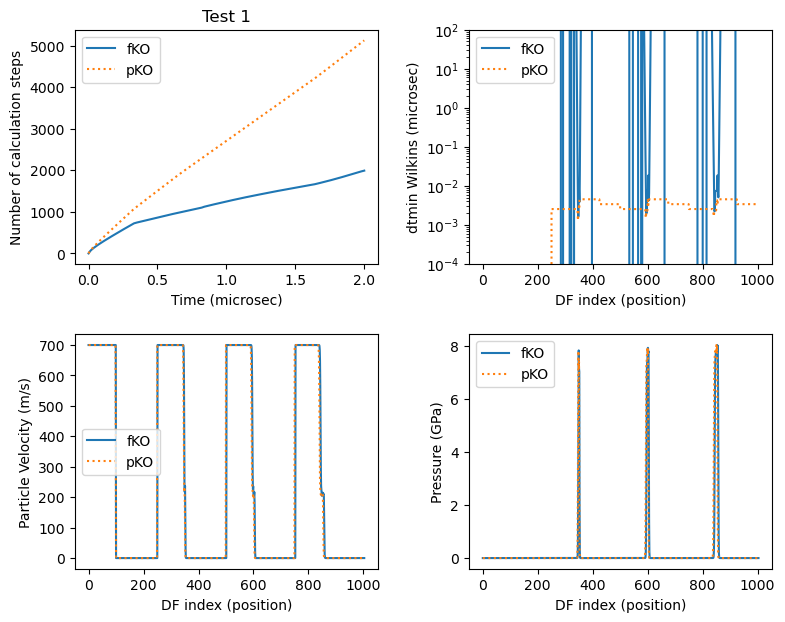

In [20]:

plt.rcParams["figure.figsize"] = (9,7)

figb, axs = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

axs[0,0].set_xlabel('Time (microsec)')
axs[0,0].set_ylabel('Number of calculation steps')


axs[0,1].set_xlabel('DF index (position)')
axs[0,1].set_ylabel('dtmin Wilkins (microsec)')


axs[1,1].set_xlabel('DF index (position)')
axs[1,1].set_ylabel('Pressure (GPa)')

axs[1,0].set_xlabel('DF index (position)')
axs[1,0].set_ylabel('Particle Velocity (m/s)')

# add title of the problem and time to the top of the plot
axs[0,0].set_title(title)

fig00a,=axs[0,0].plot(fko["time"],fko["step"],label='fKO')
fig00b,=axs[0,0].plot(pko["time"],pko["stepn"],':',label='pKO')
axs[0,0].legend()

fig01a,=axs[0,1].plot(fko["dtminj"][findex],label='fKO')
fig01b,=axs[0,1].plot(pko["dtminj"][pindex],':',label='pKO')
axs[0,1].set_ylim(0.0001,100)
axs[0,1].set_yscale('log')
axs[0,1].legend()

fig11a,=axs[1,1].plot(fko["pres"][findex],label='fKO')
fig11b,=axs[1,1].plot(pko["pres"][pindex],':',label='pKO')
axs[1,1].legend()

fig10a,=axs[1,0].plot(fko["up"][findex],label='fKO')
fig10b,=axs[1,0].plot(pko["up"][pindex],':',label='pKO')
axs[1,0].legend()



201 201
201 201


Text(0, 0.5, 'artificial viscosity q (Mbar)')

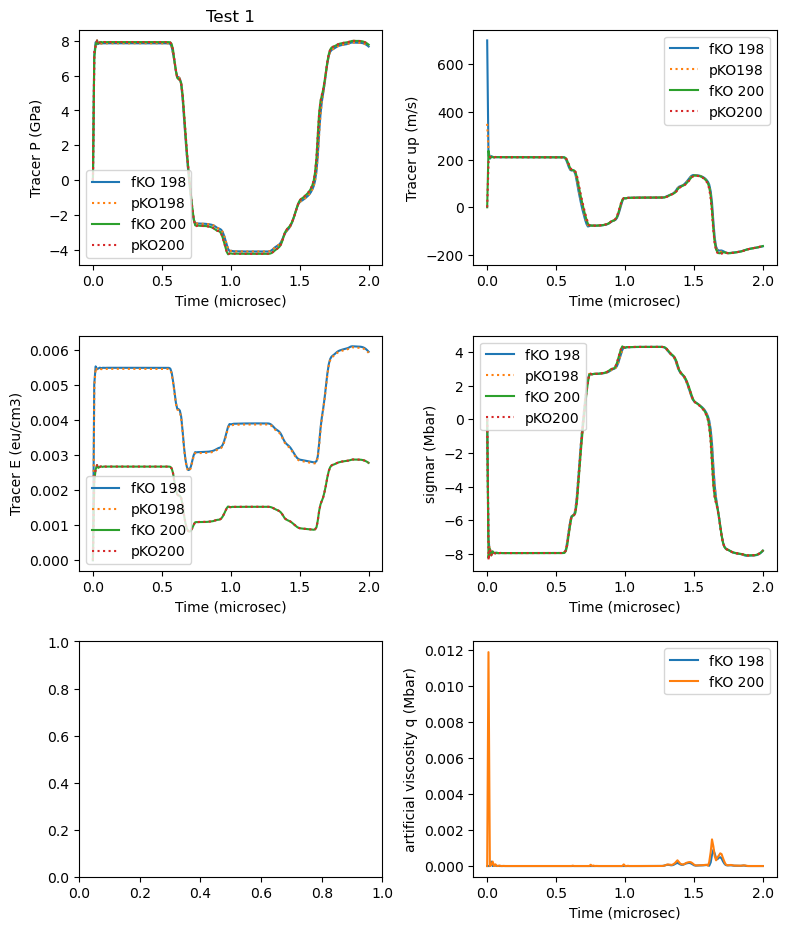

In [21]:

jtarr = [198, 200]
findex0 = np.where((fko["j"] == jtarr[0]))[0]
pindex0 = np.where((pko["j"] == jtarr[0]+1))[0]
if len(findex0) > len(pindex0):
    findex0 = np.delete(findex0,-1)
if len(pindex0) > len(findex0):
    pindex0 = np.delete(pindex0,-1)
print(len(findex0),len(pindex0))

findex1 = np.where((fko["j"] == jtarr[1]))[0]
pindex1 = np.where((pko["j"] == jtarr[1]+1))[0]
if len(findex1) > len(pindex1):
    findex1 = np.delete(findex1,-1)
if len(pindex1) > len(findex1):
    pindex1 = np.delete(pindex1,-1)
print(len(findex1),len(pindex1))

plt.rcParams["figure.figsize"] = (9,11)

figb, axs = plt.subplots(3, 2)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# add title of the problem and time to the top of the plot
axs[0,0].set_title(title)

axs[0,0].plot(ftime,fko["pres"][findex0],label='fKO '+str(jtarr[0]))
axs[0,0].plot(ptime,pko["pres"][pindex0],':',label='pKO'+str(jtarr[0]))
#res = norm(fko["P"][findex0].values-pko["P"][pindex0].values,2)
#print(res)
axs[0,0].plot(ftime,fko["pres"][findex1],label='fKO '+str(jtarr[1]))
axs[0,0].plot(ptime,pko["pres"][pindex1],':',label='pKO'+str(jtarr[1]))
#res = norm(fko["P"][findex1].values-pko["P"][pindex1].values,2)
#print(res)
axs[0,0].legend()
axs[0,0].set_xlabel('Time (microsec)')
axs[0,0].set_ylabel('Tracer P (GPa)')

axs[0,1].plot(ftime,fko["up"][findex0],label='fKO '+str(jtarr[0]))
axs[0,1].plot(ptime,pko["up"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[0,1].plot(ftime,fko["up"][findex1],label='fKO '+str(jtarr[1]))
axs[0,1].plot(ptime,pko["up"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[0,1].legend()
axs[0,1].set_xlabel('Time (microsec)')
axs[0,1].set_ylabel('Tracer up (m/s)')

axs[1,0].plot(ftime,fko["iev0"][findex0],label='fKO '+str(jtarr[0]))
axs[1,0].plot(ptime,pko["iev0"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[1,0].plot(ftime,fko["iev0"][findex1],label='fKO '+str(jtarr[1]))
axs[1,0].plot(ptime,pko["iev0"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[1,0].legend()
axs[1,0].set_xlabel('Time (microsec)')
axs[1,0].set_ylabel('Tracer E (eu/cm3)')

axs[1,1].plot(ftime,fko["sigmar"][findex0],label='fKO '+str(jtarr[0]))
axs[1,1].plot(ptime,pko["sigmar"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[1,1].plot(ftime,fko["sigmar"][findex1],label='fKO '+str(jtarr[1]))
axs[1,1].plot(ptime,pko["sigmar"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[1,1].legend()
axs[1,1].set_xlabel('Time (microsec)')
axs[1,1].set_ylabel('sigmar (Mbar)')

axs[2,1].plot(ftime,fko["q"][findex0],label='fKO '+str(jtarr[0]))
#axs[2,1].plot(ptime,pko["q"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[2,1].plot(ftime,fko["q"][findex1],label='fKO '+str(jtarr[1]))
#axs[2,1].plot(ptime,pko["q"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[2,1].legend()
axs[2,1].set_xlabel('Time (microsec)')
axs[2,1].set_ylabel('artificial viscosity q (Mbar)')


201 201
201 201


Text(0, 0.5, 'density (g/cm3)')

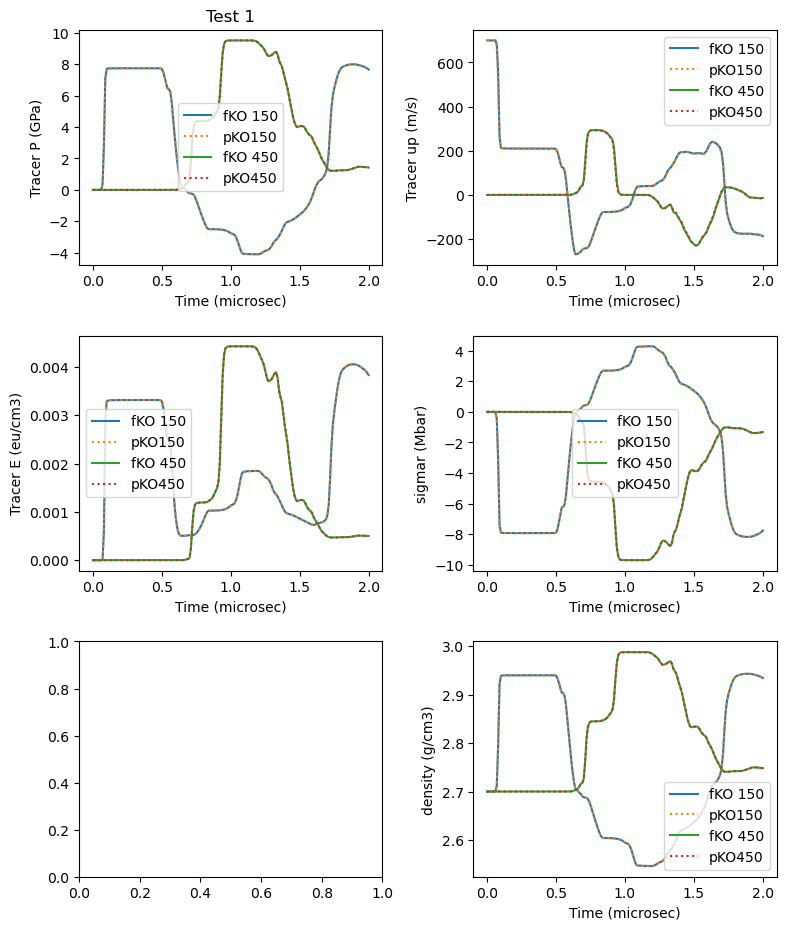

In [22]:

jtarr = [150, 450]
findex0 = np.where((fko["j"] == jtarr[0]))[0]
pindex0 = np.where((pko["j"] == jtarr[0]+1))[0]
if len(findex0) > len(pindex0):
    findex0 = np.delete(findex0,-1)
if len(pindex0) > len(findex0):
    pindex0 = np.delete(pindex0,-1)
print(len(findex0),len(pindex0))

findex1 = np.where((fko["j"] == jtarr[1]))[0]
pindex1 = np.where((pko["j"] == jtarr[1]+1))[0]
if len(findex1) > len(pindex1):
    findex1 = np.delete(findex1,-1)
if len(pindex1) > len(findex1):
    pindex1 = np.delete(pindex1,-1)
print(len(findex1),len(pindex1))

plt.rcParams["figure.figsize"] = (9,11)

figb, axs = plt.subplots(3, 2)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# add title of the problem and time to the top of the plot
axs[0,0].set_title(title)

axs[0,0].plot(ftime,fko["pres"][findex0],label='fKO '+str(jtarr[0]))
axs[0,0].plot(ptime,pko["pres"][pindex0],':',label='pKO'+str(jtarr[0]))
#res = norm(fko["P"][findex0].values-pko["P"][pindex0].values,2)
#print(res)
axs[0,0].plot(ftime,fko["pres"][findex1],label='fKO '+str(jtarr[1]))
axs[0,0].plot(ptime,pko["pres"][pindex1],':',label='pKO'+str(jtarr[1]))
#res = norm(fko["P"][findex1].values-pko["P"][pindex1].values,2)
#print(res)
axs[0,0].legend()
axs[0,0].set_xlabel('Time (microsec)')
axs[0,0].set_ylabel('Tracer P (GPa)')

axs[0,1].plot(ftime,fko["up"][findex0],label='fKO '+str(jtarr[0]))
axs[0,1].plot(ptime,pko["up"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[0,1].plot(ftime,fko["up"][findex1],label='fKO '+str(jtarr[1]))
axs[0,1].plot(ptime,pko["up"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[0,1].legend()
axs[0,1].set_xlabel('Time (microsec)')
axs[0,1].set_ylabel('Tracer up (m/s)')

axs[1,0].plot(ftime,fko["iev0"][findex0],label='fKO '+str(jtarr[0]))
axs[1,0].plot(ptime,pko["iev0"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[1,0].plot(ftime,fko["iev0"][findex1],label='fKO '+str(jtarr[1]))
axs[1,0].plot(ptime,pko["iev0"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[1,0].legend()
axs[1,0].set_xlabel('Time (microsec)')
axs[1,0].set_ylabel('Tracer E (eu/cm3)')

axs[1,1].plot(ftime,fko["sigmar"][findex0],label='fKO '+str(jtarr[0]))
axs[1,1].plot(ptime,pko["sigmar"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[1,1].plot(ftime,fko["sigmar"][findex1],label='fKO '+str(jtarr[1]))
axs[1,1].plot(ptime,pko["sigmar"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[1,1].legend()
axs[1,1].set_xlabel('Time (microsec)')
axs[1,1].set_ylabel('sigmar (Mbar)')

axs[2,1].plot(ftime,fko["rho"][findex0],label='fKO '+str(jtarr[0]))
axs[2,1].plot(ptime,pko["rho"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[2,1].plot(ftime,fko["rho"][findex1],label='fKO '+str(jtarr[1]))
axs[2,1].plot(ptime,pko["rho"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[2,1].legend()
axs[2,1].set_xlabel('Time (microsec)')
axs[2,1].set_ylabel('density (g/cm3)')


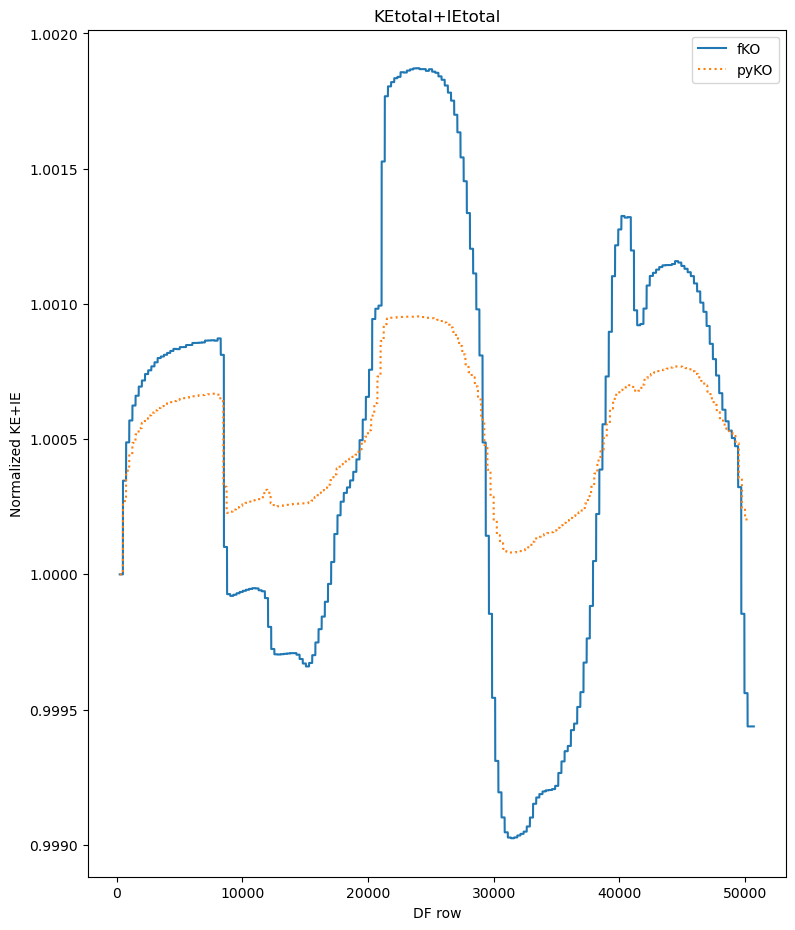

In [23]:
istart = np.where(fko['time']>0.)[0]
plt.plot(fko["etot"][istart]/fko["etot"][istart[0]],label='fKO')
istart = np.where(pko['time']>0.)[0]
plt.plot(pko["etot"][istart]/pko["etot"][istart[0]],':',label='pyKO')
plt.xlabel('DF row')
plt.title('KEtotal+IEtotal')
plt.ylabel('Normalized KE+IE')
plt.legend()


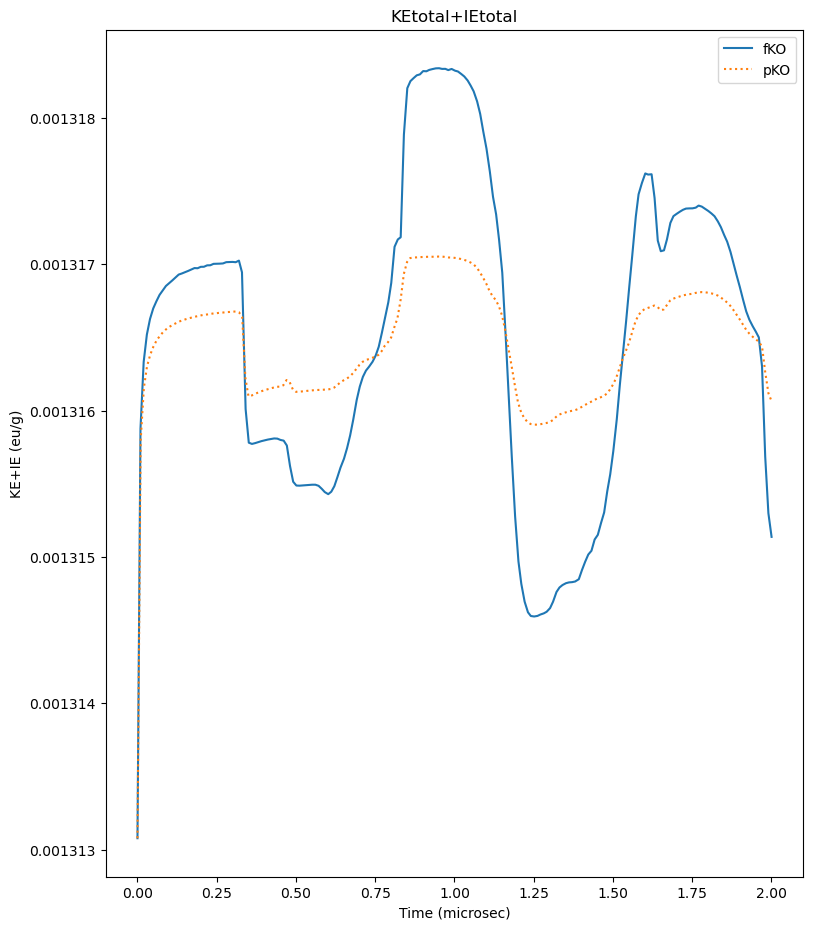

In [24]:
plt.plot(fko['time'],fko['etot'],label='fKO')
plt.plot(pko['time'],pko['etot'],':',label='pKO')
plt.xlabel('Time (microsec)')
plt.title('KEtotal+IEtotal')
plt.ylabel('KE+IE (eu/g)')
#plt.ylabel('KE+IE (J/kg)')
plt.legend()


End of notebook